In [1]:
%load_ext autoreload
%autoreload 2

This notebook aims to demonstrate the genericity of our approaches by utilizing a **sample of Embraceplus data** (requested by the Empatica website).

Specifically, we will demonstrate the following:
- Non-wear detection (and the non-wear detection visulaization)
- Skin conductance signal processing


In [1]:
import os
import sys

sys.path.append("../")

import pandas as pd
import numpy as np
import glob

from itertools import cycle
from pathlib import Path

import plotly.express as px
import plotly.graph_objects as go
from functional import seq
from plotly.subplots import make_subplots
from plotly_resampler import FigureResampler
from plotly_resampler.aggregation import MedDiffGapHandler

from code_utils.embraceplus import AvroParser
from code_utils.embraceplus.nonwear import embraceplus_wrist_pipeline
from code_utils.empatica.scl_processing import process_gsr_pipeline
from code_utils.empatica.processing_visualization import plot_gsr_cols
from code_utils.path_conf import loc_data_dir

USE_PNG = True

In [2]:
# load the data
# NOTE: RAW EmbracePlus data is provided in the form of avro files

#avro_paths = list(Path(loc_data_dir).rglob("EmbracePlus*/**/*.avro")) # Test on some files

root_path = "../loc_data/participant_data/"
pattern = os.path.join(root_path, "2025-04-*", "TEST2-3YK3L151MP", "raw_data", "v6", "*.avro") # Oriented date and user selection version
avro_paths = glob.glob(pattern)

avros = []
for avro_path in avro_paths:
    #print(avro_path)
    avro_list = AvroParser.parse_avro_file(avro_path)
    assert (len(avro_list)) == 1
    avros.extend(avro_list)
    del avro_list

del avro_path


In [4]:
# Look at the metadata of the first two avro files
display(avros[0]["metadata"])
display(avros[1]["metadata"])

{'deviceSn': '3YK32132NP',
 'deviceModel': 'EMBRACEPLUS',
 'hwVersion': {'major': 6, 'minor': 0, 'patch': 1},
 'enrollment': {'participantID': 'P0001',
  'siteID': 'TSTSITE',
  'studyID': 'TSTSTUDY',
  'organizationID': 'TSTORG'},
 'fwVersion': {'major': 4, 'minor': 1, 'patch': 1},
 'schemaVersion': {'major': 6, 'minor': 3, 'patch': 0},
 'algoVersion': {'major': 7, 'minor': 0, 'patch': 1},
 'timezone': 7200,
 'filePath': 'C:\\Users\\Admin\\Documents\\GitHub\\data-quality-challenges-wearables\\notebooks\\..\\loc_data\\EmbracePlus Data Sample\\raw_data\\TSTSTUDY-TSTSITE-P0001_1654326591.avro'}

{'deviceSn': '3YK32132NP',
 'deviceModel': 'EMBRACEPLUS',
 'hwVersion': {'major': 6, 'minor': 0, 'patch': 1},
 'enrollment': {'participantID': 'P0001',
  'siteID': 'TSTSITE',
  'studyID': 'TSTSTUDY',
  'organizationID': 'TSTORG'},
 'fwVersion': {'major': 4, 'minor': 1, 'patch': 1},
 'schemaVersion': {'major': 6, 'minor': 3, 'patch': 0},
 'algoVersion': {'major': 7, 'minor': 0, 'patch': 1},
 'timezone': 7200,
 'filePath': 'C:\\Users\\Admin\\Documents\\GitHub\\data-quality-challenges-wearables\\notebooks\\..\\loc_data\\EmbracePlus Data Sample\\raw_data\\TSTSTUDY-TSTSITE-P0001_1654352541.avro'}

In [5]:
# THe metadata is the same, so we can merge the avros
merged_avros = AvroParser.merge_avro_data(avros)

## *Demo 1*: on-wrist detection

In [6]:
df_eda = merged_avros["eda"].set_index("timestamp").last('1h')
df_tmp = merged_avros["tmp"].set_index("timestamp").last('1h')
df_acc = merged_avros["acc"].set_index("timestamp").last('1h')
df_bvp = merged_avros["bvp"].set_index("timestamp").last('1h')


out = embraceplus_wrist_pipeline.process(
    [df_eda, df_tmp, df_acc], return_all_series=False, return_df=False
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_15460\2847516480.py:1: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  df_eda = merged_avros["eda"].set_index("timestamp").last('1h')
C:\Users\Admin\AppData\Local\Temp\ipykernel_15460\2847516480.py:2: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  df_tmp = merged_avros["tmp"].set_index("timestamp").last('1h')
C:\Users\Admin\AppData\Local\Temp\ipykernel_15460\2847516480.py:3: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  df_acc = merged_avros["acc"].set_index("timestamp").last('1h')
C:\Users\Admin\AppData\Local\Temp\ipykernel_15460\2847516480.py:4: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  df_bvp = merged_avros["

In [ ]:
fig = FigureResampler(
    make_subplots(
        rows=4,
        cols=1,
        shared_xaxes=True,
        vertical_spacing=0.06,
        subplot_titles=[
            "(i) Skin Conductance",
            "(ii) Skin Temperature",
            "(iii) ACC_x-SD (w=1s)",
            "(iv) Raw ACC",
        ],
        specs=[[{"secondary_y": True}] for _ in range(4)],
    ),
    default_n_shown_samples=1000,
    show_mean_aggregation_size=False,
    resampled_trace_prefix_suffix=("", ""),
)


# ROW 1 -----------------------------------------------------
for col in df_eda.columns:
    s_c = df_eda[col]
    fig.add_trace(go.Scatter(name=col, opacity=0.4), hf_x=s_c.index, hf_y=s_c)

for col in ["EDA_SQI"]:
    s_c = seq(out).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(name=col, opacity=0.8),
        hf_x=s_c.index,
        hf_y=s_c.astype(float),
        secondary_y=True,
    )

# ROW 2 -----------------------------------------------------
for col in df_tmp.columns:
    fig.add_trace(
        go.Scatter(name=col, opacity=0.4, legend="legend2"),
        hf_x=df_tmp[col].index,
        hf_y=df_tmp[col],
        row=2,
        col=1,
        limit_to_view=True,
    )


for col in ["TMP_SQI"]:
    s_c = seq(out).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(name=col, opacity=0.8, legend="legend2"),
        hf_x=s_c.index,
        hf_y=s_c.astype(float),
        row=2,
        col=1,
        secondary_y=True,
    )

# ROW 3 -----------------------------------------------------
for col in ["AI"]:
    s_c = seq(out).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(opacity=0.4, name="ACC_x SD", legend="legend3"),
        hf_x=np.ascontiguousarray(s_c.index),
        hf_y=np.ascontiguousarray(s_c.values),
        row=3,
        col=1,
    )


for col in ["AI_SQI"]:
    s_c = seq(out).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(name="ACC-SD SQI", opacity=0.6, line_width=1, legend="legend3"),
        hf_x=s_c.index,
        hf_y=s_c.astype(float),
        secondary_y=True,
        row=3,
        col=1,
    )


# ROW 4 -----------------------------------------------------
for col in df_acc.columns:
    fig.add_trace(
        go.Scatter(name=f"{col}", opacity=0.4, legend="legend4"),
        hf_x=df_acc[col].index,
        hf_y=df_acc[col],
        row=4,
        col=1,
    )

for col in ["Wrist_SQI", "On_Wrist_SQI_smoothened"][1:]:
    s_c = seq(out).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(
            name="Wrist_SQI", line_color="#fd5c63", line_width=4, legend="legend4"
        ),
        hf_x=s_c.index,
        hf_y=s_c.astype(float),
        row=4,
        col=1,
        secondary_y=True,
    )


# ---------------------- LAYOUT --------------------------------
fig.update_layout(template="plotly_white", height=750)
fig.update_layout(
    legend=dict(
        **dict(orientation="h", yanchor="bottom", xanchor="left", font_size=19),
        **dict(y=1.0, x=0, itemsizing="constant"),
    ),
    legend2=dict(
        **dict(orientation="h", yanchor="bottom", xanchor="left", font_size=19),
        **dict(y=0.73, x=0, itemsizing="constant"),
    ),
    legend3=dict(
        **dict(orientation="h", yanchor="bottom", xanchor="left", font_size=19),
        **dict(y=0.47, x=0, itemsizing="constant"),
    ),
    legend4=dict(
        **dict(orientation="h", yanchor="bottom", xanchor="left", font_size=19),
        **dict(y=0.21, x=0, itemsizing="constant"),
    ),
)


from datetime import datetime, timedelta

# Extraire les jours uniques dans les données
dates = pd.to_datetime(df_eda.index.date).unique()

for date in dates:
    # Plage 00:00 à 06:00 du jour
    start_early = datetime.combine(date, datetime.min.time())
    end_early = start_early + pd.Timedelta(hours=6)
    fig.add_vrect(
        x0=start_early,
        x1=end_early,
        fillcolor="rgba(128, 128, 128, 0.1)",  # gris léger
        line_width=0,
        layer="below",
        row="all",
        col=1,
    )

    # Plage 23:00 à 00:00 du même jour
    start_late = start_early + pd.Timedelta(hours=23)
    end_late = start_early + pd.Timedelta(days=1)
    fig.add_vrect(
        x0=start_late,
        x1=end_late,
        fillcolor="rgba(128, 128, 128, 0.1)",  # même gris
        line_width=0,
        layer="below",
        row="all",
        col=1,
    )


fig.update_yaxes(title_text="μS", row=1, col=1, title_font_size=20)
fig.update_yaxes(title_text="°C", row=2, col=1, title_font_size=20)
fig.update_yaxes(title_text="g", row=3, col=1, title_font_size=20)
fig.update_yaxes(title_text="g", row=4, col=1, title_font_size=20)

fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))
fig.update_annotations(font_size=24)
# update tick sizes
fig.update_xaxes(tickfont_size=18)
fig.update_yaxes(tickfont_size=18)

# do not show seconds on the y-axis
fig.update_yaxes(visible=False, secondary_y=True, range=[-.05, 1.05])

fig.show_dash(mode="inline", port=8002)
if USE_PNG:
    fig.show(renderer="png", width=1650, height=750)

**notes**:
- As outline in the [embraceplus/nonwear.py](../code_utils/embraceplus/nonwear.py), minimal code was adapted w.r.t. the original Empatica E4 code.
- The above visualization is a copy of the original Empatica E4 visualization

This hints a genericity of our E4 approach towards the Embraceplus device.


Remark that, as we do not have a lot of EmbracePlus data, it is hard to make statements about the performance of the non-wear detection and its current parameters.

### Signal processing

In [8]:
eda_slc = merged_avros["eda"].set_index("timestamp").last('1h')
out = process_gsr_pipeline(eda_slc, use_scr_pipeline=False, n_jobs=1)

EDA_SQI------------------------------
EDA_SQI_smoothend------------------------------
EDA_delta_SQI------------------------------
EDA_lf_1Hz------------------------------
EDA_lf_cleaned------------------------------
EDA_lost_SQI------------------------------
EDA_noise_SQI------------------------------
EDA_slope_SQI------------------------------
noise------------------------------
noise_mean_2s------------------------------
raw_cleaned------------------------------
raw_cleaned_duration_filter------------------------------
slope------------------------------


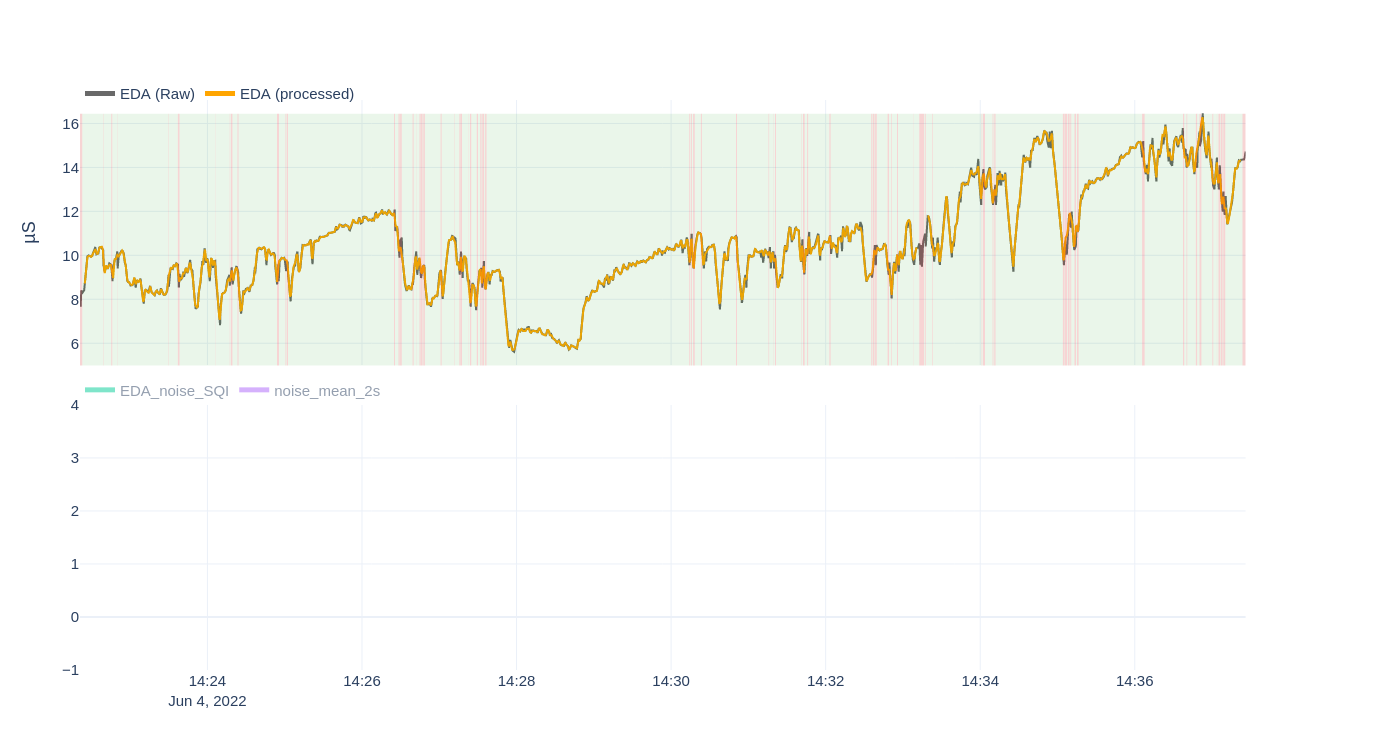

In [9]:
eda_cleaned = out["EDA_lf_cleaned"]

fig = FigureResampler(
    make_subplots(
        rows=2,
        cols=1,
        shared_xaxes=True,
        specs=[[{"secondary_y": True}], [{"secondary_y": True}]],
        vertical_spacing=0.07,
        # colorway=px.colors.qualitative.Plotly,
    ),
    show_mean_aggregation_size=False,
    resampled_trace_prefix_suffix=("", ""),
)

# ROW 1 -----------------------------------------------------
fig.add_trace(
    go.Scatter(name="EDA (Raw)", line_color="dimgrey", legend="legend1"),
    **{"hf_x": eda_slc.index, "hf_y": eda_slc["EDA"], "row": 1, "col": 1},
)
fig.add_trace(
    go.Scatter(name="EDA (processed)", line_color="orange", legend="legend1"),
    **{"hf_x": eda_cleaned.index, "hf_y": eda_cleaned, "row": 1, "col": 1},
)


# ROW 2 -----------------------------------------------------
plot_gsr_cols(
    fig,
    out,
    row_idx=1,
    add_skip_cols=["EDA_delta_SQI", "noise", "EDA_lf_cleaned"],
    palette=cycle(px.colors.qualitative.Plotly[2:]),
)


# Set the layout
fig.update_layout(
    template="plotly_white",
    height=650,
    legend1=dict(
        y=1.04,
        bgcolor="rgba(0,0,0,0)",
        orientation="h",
        font_size=15,
        itemsizing="constant",
    ),
    legend2=dict(
        y=0.52,
        bgcolor="rgba(0,0,0,0)",
        orientation="h",
        font_size=15,
        itemsizing="constant",
    ),
    # update the font_size of the axis ticks labels
    font=dict(size=15),
)

# hide the tick-labels of the secondary y-axes
fig.update_yaxes(title_text="µS", row=1, col=1, titlefont_size=18)
fig.update_yaxes(visible=False, showticklabels=False, row=1, col=1, secondary_y=True)
fig.update_yaxes(
    visible=False, showticklabels=False, row=2, col=1, range=[-2, 1.1], secondary_y=True
)
#     fig.show(renderer="png", width=1400, height=750)
fig.show_dash(port=8002, mode="inline")

if USE_PNG:
    fig.show(renderer="png", width=1400, height=750)

**notes**:

- This code is a straight copy from the Empatica E4 code, again hinting at the genericity of our approach.

The same remark as above applies here: we cannot make statements about the performance of the signal processing and its current parameters due to the lack of data.